# Imports

In [1]:
import logging
import os

import pandas as pd
import seaborn as sns

import core.config.config_ as ccocon
import helpers.dbg as hdbg
import helpers.env as henv
import helpers.printing as hprintin
import helpers.s3 as hs3
import im.data.universe as imdauni
import research.cc.statistics as rccsta
import research.cc.volume as rccvol
import im.ccxt.data.load.loader as imccdaloloa

import core.plotting as cplot

In [2]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprintin.config_notebook()

INFO: > cmd='/venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-abe60107-76c1-4344-8445-ba17c4ae5c88.json'
>>ENV<<: is_inside_container=True: code_version=None, container_version=cmamp-1.0.0, is_inside_docker=True, is_inside_ci=False, CI_defined=True, CI=''
>>ENV<<: AM_AWS_PROFILE=True AM_ECR_BASE_PATH=True AM_S3_BUCKET=True AM_TELEGRAM_TOKEN=True AWS_ACCESS_KEY_ID=False AWS_DEFAULT_REGION=False AWS_SECRET_ACCESS_KEY=False GH_ACTION_ACCESS_TOKEN=True
-----------------------------------------------------------------------------
This code is not in sync with the container:
code_version='None' != container_version='cmamp-1.0.0'
-----------------------------------------------------------------------------
You need to:
- merge origin/master into your branch with `invoke git_merge_master`
- pull the latest container with `invoke docker_pull`
# Git
    branch_name='CMTask260_New_iteration_of_volume_notebook'
    hash='1dd17607'
    # Last comm

# Config

In [3]:
def get_cmtask260_config() -> ccocon.Config:
    """
    Get task260-specific config.
    """
    config = ccocon.Config()
    # Load parameters.
    config.add_subconfig("load")
    config["load"]["aws_profile"] = "am"
    config["load"]["data_dir"] = os.path.join(hs3.get_path(), "data")
    # Data parameters.
    config.add_subconfig("data")
    config["data"]["data_type"] = "OHLCV"
    config["data"]["universe_version"] = "v0_3"
    # Column names.
    config.add_subconfig("column_names")
    config["column_names"]["volume"] = "volume"
    config["column_names"]["currency_pair"] = "currency_pair"
    config["column_names"]["exchange"] = "exchange_id"
    config["column_names"]["close"] = "close"
    return config


config = get_cmtask260_config()
print(config)

load:
  aws_profile: am
  data_dir: s3://alphamatic-data/data
data:
  data_type: OHLCV
  universe_version: v0_3
column_names:
  volume: volume
  currency_pair: currency_pair
  exchange: exchange_id
  close: close


# Load the data

In [4]:
compute_daily_cumul_volume_ = lambda data: rccvol.get_daily_cumul_volume(
    data, config, is_notional_volume=False
)

cumul_daily_volume = rccsta.compute_stats_for_universe(config, compute_daily_cumul_volume_)

Reading CCXT data for exchange id='binance', currencies='ADA/USDT' from file='s3://alphamatic-data/data/ccxt/20210924/binance/ADA_USDT.csv.gz'...
Processing CCXT data for exchange id='binance', currencies='ADA/USDT'...
Index length increased by 4520 = 1622000 - 1617480
Reading CCXT data for exchange id='binance', currencies='AVAX/USDT' from file='s3://alphamatic-data/data/ccxt/20210924/binance/AVAX_USDT.csv.gz'...
Processing CCXT data for exchange id='binance', currencies='AVAX/USDT'...
Index length increased by 1224 = 517498 - 516274
Reading CCXT data for exchange id='binance', currencies='BNB/USDT' from file='s3://alphamatic-data/data/ccxt/20210924/binance/BNB_USDT.csv.gz'...
Processing CCXT data for exchange id='binance', currencies='BNB/USDT'...
Index length increased by 4520 = 1622295 - 1617775
Reading CCXT data for exchange id='binance', currencies='BTC/USDT' from file='s3://alphamatic-data/data/ccxt/20210924/binance/BTC_USDT.csv.gz'...
Processing CCXT data for exchange id='binan

Index length increased by 94496 = 1619786 - 1525290
Reading CCXT data for exchange id='kucoin', currencies='DOGE/USDT' from file='s3://alphamatic-data/data/ccxt/20210924/kucoin/DOGE_USDT.csv.gz'...
Processing CCXT data for exchange id='kucoin', currencies='DOGE/USDT'...
Index length=314817 has not changed
Reading CCXT data for exchange id='kucoin', currencies='EOS/USDT' from file='s3://alphamatic-data/data/ccxt/20210924/kucoin/EOS_USDT.csv.gz'...
Processing CCXT data for exchange id='kucoin', currencies='EOS/USDT'...
Index length increased by 232290 = 1621431 - 1389141
Reading CCXT data for exchange id='kucoin', currencies='ETH/USDT' from file='s3://alphamatic-data/data/ccxt/20210924/kucoin/ETH_USDT.csv.gz'...
Processing CCXT data for exchange id='kucoin', currencies='ETH/USDT'...
Index length increased by 117548 = 1619960 - 1502412
Reading CCXT data for exchange id='kucoin', currencies='FIL/USDT' from file='s3://alphamatic-data/data/ccxt/20210924/kucoin/FIL_USDT.csv.gz'...
Processing 

In [5]:
_LOG.info("The number of (exchanges, currency pairs) =%s", cumul_daily_volume.shape[0])
cumul_daily_volume.head(3)

The number of (exchanges, currency pairs) =19629


,exchange_id,currency_pair,date,volume,vendor
0,binance,ADA/USDT,2018-08-16,36785174.6,CCXT
1,binance,ADA/USDT,2018-08-17,260602766.5,CCXT
2,binance,ADA/USDT,2018-08-18,166586335.9,CCXT


# Compute total volume per exchange

exchange_id
binance    2.386714e+12
kucoin     8.298311e+10
ftx        4.859575e+10
gateio     1.790395e+10
Name: volume, dtype: float64


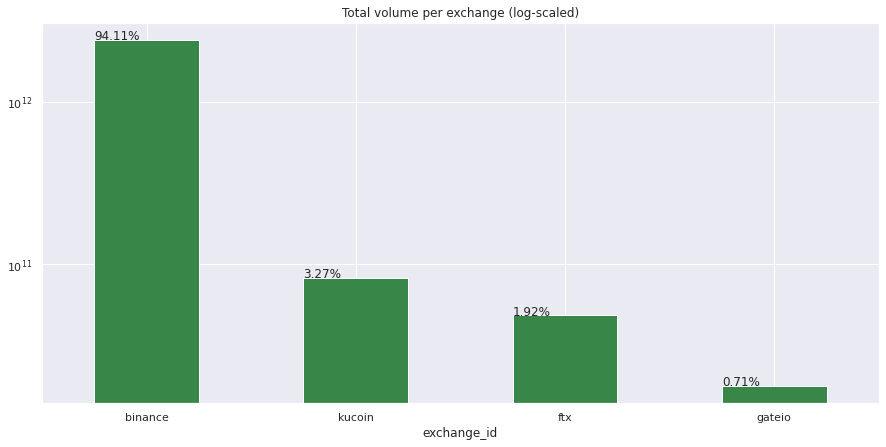

In [6]:
total_volume_by_exchange = rccvol.get_total_exchange_volume(
    cumul_daily_volume, config, avg_daily=False
)
print(total_volume_by_exchange)

# Compute total volume per currency

currency_pair
DOGE/USDT    2.028142e+12
ADA/USDT     3.799040e+11
XRP/USDT     3.374002e+10
BTC/USDT     2.721637e+10
EOS/USDT     2.108024e+10
ETH/USDT     1.987232e+10
LINK/USDT    1.032285e+10
BNB/USDT     7.497330e+09
SOL/USDT     5.676799e+09
AVAX/USDT    1.719189e+09
FIL/USDT     1.025434e+09
Name: volume, dtype: float64


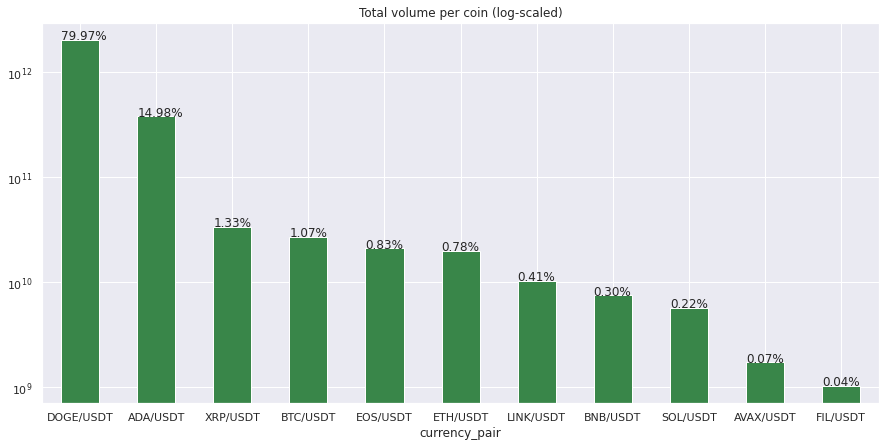

In [7]:
total_volume_by_coins = rccvol.get_total_coin_volume(
    cumul_daily_volume, config, avg_daily=False
)
print(total_volume_by_coins)

# Rolling Plots

## By exchange

     exchange_id        date        volume  rolling_volume
0        binance  2018-08-16  3.983483e+07             NaN
1        binance  2018-08-17  2.785477e+08             NaN
2        binance  2018-08-18  1.749467e+08             NaN
3        binance  2018-08-19  1.327497e+08             NaN
4        binance  2018-08-20  1.615476e+08             NaN
...          ...         ...           ...             ...
2884      kucoin  2021-09-11  1.763054e+08    2.210660e+08
2885      kucoin  2021-09-12  1.926238e+08    2.219051e+08
2886      kucoin  2021-09-13  1.932818e+08    2.229066e+08
2887      kucoin  2021-09-14  1.306517e+08    2.229543e+08
2888      kucoin  2021-09-15  7.306304e+07    2.228776e+08

[2889 rows x 4 columns]


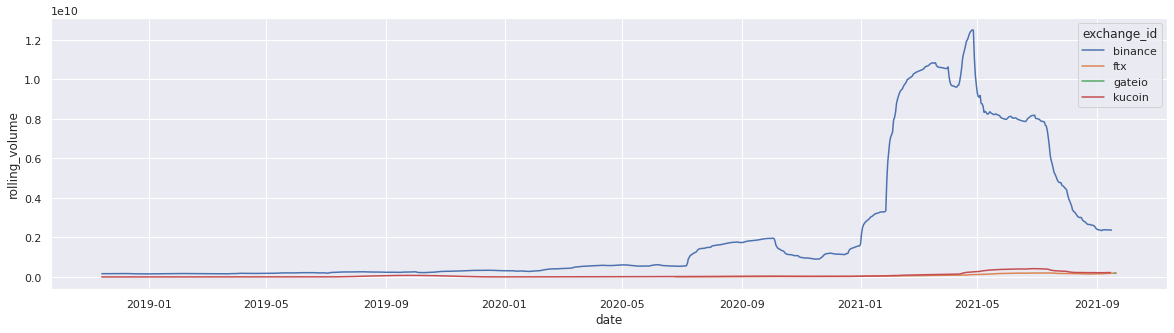

In [8]:
rolling_volume_per_exchange = rccvol.get_rolling_volume_per_exchange(
    cumul_daily_volume, config, window=90
)
print(rolling_volume_per_exchange)

## By coins

     currency_pair        date        volume  rolling_volume
0         ADA/USDT  2018-08-16  3.678517e+07             NaN
1         ADA/USDT  2018-08-17  2.606028e+08             NaN
2         ADA/USDT  2018-08-18  1.665863e+08             NaN
3         ADA/USDT  2018-08-19  1.256888e+08             NaN
4         ADA/USDT  2018-08-20  1.484363e+08             NaN
...            ...         ...           ...             ...
9600      XRP/USDT  2021-09-17  2.225229e+07    9.356634e+07
9601      XRP/USDT  2021-09-18  1.286638e+07    9.314457e+07
9602      XRP/USDT  2021-09-19  2.317895e+07    9.189960e+07
9603      XRP/USDT  2021-09-20  4.234616e+07    9.067459e+07
9604      XRP/USDT  2021-09-21  8.289725e+06    8.957022e+07

[9605 rows x 4 columns]


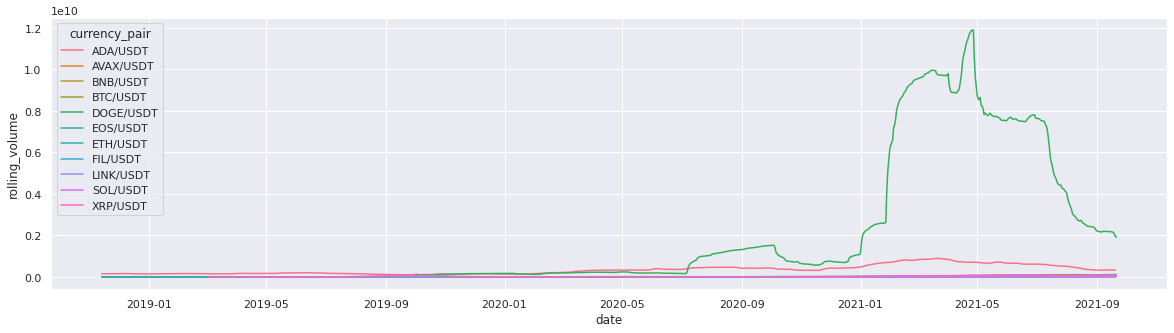

In [9]:
rolling_volume_per_coin = rccvol.get_rolling_volume_per_coin(
    cumul_daily_volume, config, window=90
)
print(rolling_volume_per_coin)

# Compare weekday volumes

weekday
Thursday     4.825185e+11
Friday       3.766262e+11
Sunday       3.634226e+11
Saturday     3.534757e+11
Wednesday    3.383253e+11
Monday       3.128843e+11
Tuesday      3.089442e+11
Name: volume, dtype: float64


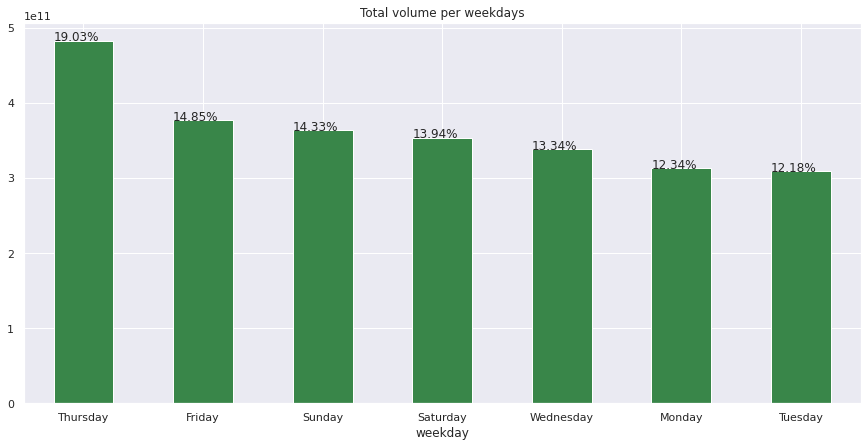

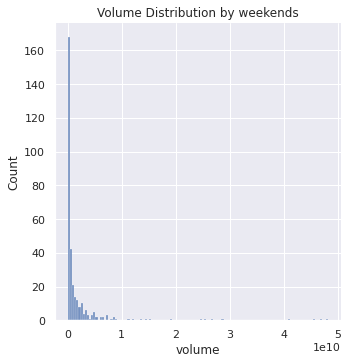

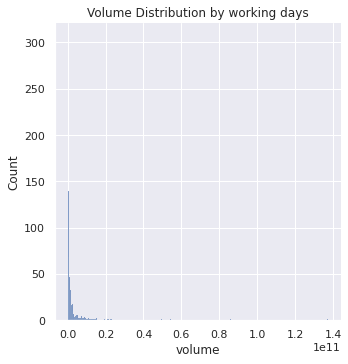

In [10]:
total_volume_by_weekdays = rccvol.compare_weekday_volumes(
    cumul_daily_volume, config
)
print(total_volume_by_weekdays)

# Compare ATH volumes

## Functions

In [29]:
def get_initial_df_with_volumes(coins, exchange, is_notional_volume):
    """
    Return DataFrame with the volume of all coins for exchange with initial timestamps
    Parameters: list of coins, exchange name
    """
    result = []
    loader = imccdaloloa.CcxtLoader(root_dir="s3://alphamatic-data/data", aws_profile="am")
    for coin in coins:
        df = loader.read_data_from_filesystem(
            exchange_id=exchange, currency_pair=coin, data_type="OHLCV"
        )
        if is_notional_volume:
            df["volume"]=df["volume"]*df["close"]
        result.append(df["volume"])
    final_result = pd.concat(result, axis=1)
    return final_result


def plot_ath_volumes_comparison(df_list):
    """
    Return the graph with the comparison of average minute total trading volume
    in ATH vs.

    non-ATH
    Parameters: dataframe with volumes from a given exchange
    """
    plot_df = []
    for df in df_list:
        df_ath = df.iloc[df.index.indexer_between_time("09:30", "16:00")]
        df_not_ath = df.loc[~df.index.isin(df_ath.index)]
        ath_stat = pd.DataFrame()
        ath_stat.loc[df.name, f"minute_avg_total_volume_ath_{df.name}"] = (
            df_ath.sum().sum() / df_ath.shape[0]
        )
        ath_stat.loc[
            df.name, f"minute_avg_total_volume_not_ath_{df.name}"
        ] = (df_not_ath.sum().sum() / df_not_ath.shape[0])
        plot_df.append(ath_stat)
    plot_df = pd.concat(plot_df)
    plot_df.plot.bar(figsize=(15, 7), logy=True)

## Load the data

In [31]:
# get the list of all coin paires for each exchange
binance_coins = imdauni.get_trade_universe("v0_1")["CCXT"]["binance"]
ftx_coins = imdauni.get_trade_universe("v0_1")["CCXT"]["ftx"]
gateio_coins = imdauni.get_trade_universe("v0_1")["CCXT"]["gateio"]
kucoin_coins = imdauni.get_trade_universe("v0_1")["CCXT"]["kucoin"]

# load all the dataframes
binance_1 = get_initial_df_with_volumes(binance_coins, "binance", is_notional_volume=True)
ftx_1 = get_initial_df_with_volumes(ftx_coins, "ftx", is_notional_volume=True)
gateio_1 = get_initial_df_with_volumes(gateio_coins, "gateio", is_notional_volume=True)
kucoin_1 = get_initial_df_with_volumes(kucoin_coins, "kucoin", is_notional_volume=True)

# supportive variables
exchange_list = [binance_1, ftx_1, gateio_1, kucoin_1]
binance_1.name = "binance"
ftx_1.name = "ftx"
gateio_1.name = "gateio"
kucoin_1.name = "kucoin"

Reading CCXT data for exchange id='binance', currencies='ADA/USDT' from file='s3://alphamatic-data/data/ccxt/20210924/binance/ADA_USDT.csv.gz'...
Processing CCXT data for exchange id='binance', currencies='ADA/USDT'...
Index length increased by 4520 = 1622000 - 1617480
Reading CCXT data for exchange id='binance', currencies='AVAX/USDT' from file='s3://alphamatic-data/data/ccxt/20210924/binance/AVAX_USDT.csv.gz'...
Processing CCXT data for exchange id='binance', currencies='AVAX/USDT'...
Index length increased by 1224 = 517498 - 516274
Reading CCXT data for exchange id='binance', currencies='BNB/USDT' from file='s3://alphamatic-data/data/ccxt/20210924/binance/BNB_USDT.csv.gz'...
Processing CCXT data for exchange id='binance', currencies='BNB/USDT'...
Index length increased by 4520 = 1622295 - 1617775
Reading CCXT data for exchange id='binance', currencies='BTC/USDT' from file='s3://alphamatic-data/data/ccxt/20210924/binance/BTC_USDT.csv.gz'...
Processing CCXT data for exchange id='binan

Index length increased by 94496 = 1619786 - 1525290
Reading CCXT data for exchange id='kucoin', currencies='DOGE/USDT' from file='s3://alphamatic-data/data/ccxt/20210924/kucoin/DOGE_USDT.csv.gz'...
Processing CCXT data for exchange id='kucoin', currencies='DOGE/USDT'...
Index length=314817 has not changed
Reading CCXT data for exchange id='kucoin', currencies='EOS/USDT' from file='s3://alphamatic-data/data/ccxt/20210924/kucoin/EOS_USDT.csv.gz'...
Processing CCXT data for exchange id='kucoin', currencies='EOS/USDT'...
Index length increased by 232290 = 1621431 - 1389141
Reading CCXT data for exchange id='kucoin', currencies='ETH/USDT' from file='s3://alphamatic-data/data/ccxt/20210924/kucoin/ETH_USDT.csv.gz'...
Processing CCXT data for exchange id='kucoin', currencies='ETH/USDT'...
Index length increased by 117548 = 1619960 - 1502412
Reading CCXT data for exchange id='kucoin', currencies='FIL/USDT' from file='s3://alphamatic-data/data/ccxt/20210924/kucoin/FIL_USDT.csv.gz'...
Processing 

## Plot

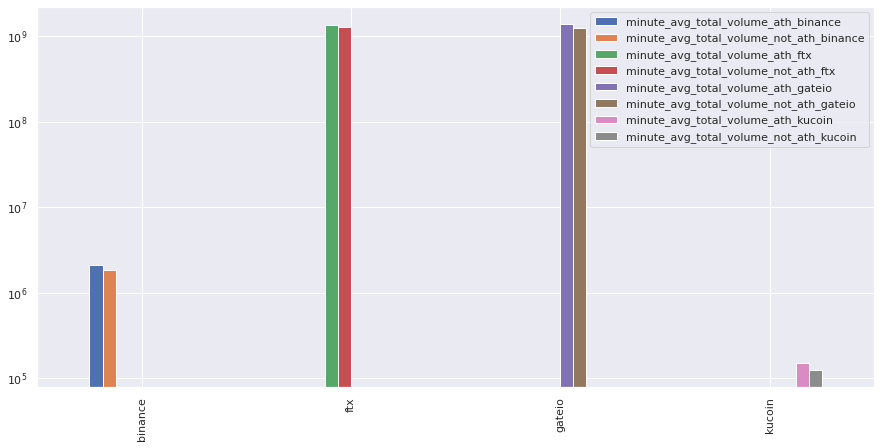

In [33]:
plot_ath_volumes_comparison(exchange_list)